This notebook is to build the regression and quantile regressions of the anual generation for Wind Power Plants

In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, validation_curve, learning_curve, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, get_scorer_names, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from statsmodels import api as sm
import joblib
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
from mapie.quantile_regression import MapieQuantileRegressor
from pprint import pprint


# DATAFRAMES

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

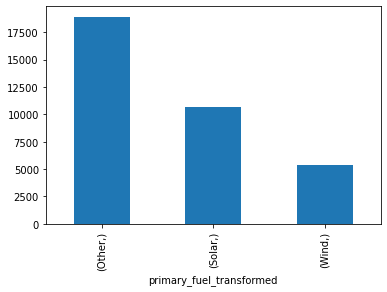

In [2]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                    ]
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [3]:
df_wind = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Wind"]
df_wind

,latitude,longitude,ANN_ALLSKY_SFC_SW_DNI_2013,ANN_ALLSKY_SFC_SW_DNI_2014,ANN_ALLSKY_SFC_SW_DNI_2015,ANN_ALLSKY_SFC_SW_DNI_2016,ANN_ALLSKY_SFC_SW_DNI_2017,ANN_ALLSKY_SFC_SW_DNI_2018,ANN_ALLSKY_SFC_SW_DNI_2019,ANN_ALLSKY_SFC_SW_DWN_2013,...,std_WS50M_RANGE_AVG_2019,name,capacity_mw,primary_fuel_transformed,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
index,,,,,,,,,,,,,,,,,,,,,
91,-77.8428,166.7271,4.40,4.26,4.26,4.71,4.58,4.07,4.16,2.95,...,0.878,Ross Island,1.00,Wind,NaN,NaN,NaN,NaN,NaN,NaN
139,-45.8467,-67.4964,5.64,5.46,5.74,5.69,5.32,5.69,5.80,4.43,...,1.272,COMODORO RIVADAVIA - ANTONIO MORAN,16.56,Wind,NaN,NaN,NaN,NaN,NaN,NaN
238,-37.4309,-64.7160,6.18,6.09,5.64,5.63,6.08,5.96,6.23,5.03,...,0.620,GENERAL ACHA,1.80,Wind,NaN,NaN,NaN,NaN,NaN,NaN
264,-39.2291,-62.6497,5.94,5.90,5.62,5.62,5.86,5.79,5.86,4.83,...,0.719,MAYOR BURATOVICH,2.02,Wind,NaN,NaN,NaN,NaN,NaN,NaN
278,-28.6684,-66.7524,7.83,7.64,7.12,6.91,7.56,7.08,7.15,6.11,...,0.768,PARQUE EOLICO ARAUCO SAPEM I,25.20,Wind,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34684,9.2351,105.8048,3.15,3.62,3.91,3.40,3.11,3.15,3.81,4.78,...,0.212,Bac Lieu Wind power,99.00,Wind,NaN,NaN,NaN,NaN,NaN,NaN
34845,10.5507,108.9300,4.22,4.96,5.30,4.53,4.01,4.43,4.94,5.35,...,0.385,Phu Quy,6.00,Wind,NaN,NaN,NaN,NaN,NaN,NaN
34846,13.9077,109.2600,3.68,4.31,4.69,3.87,3.67,3.94,4.46,4.88,...,0.763,Phuong Mai 3,21.00,Wind,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
LIST_YEARS = ['2013', '2014', '2015', '2016', '2017', '2018']
dict_df_years = {}

for year in LIST_YEARS:
    df_aux = df_wind[df_wind[f'generation_gwh_{year}'].notna()]
    columns_keep_aux = df_aux.columns.str.contains(year) | df_aux.columns.str.contains('capacity_mw')
    df_aux = df_aux.loc[:,columns_keep_aux]
    df_aux = df_aux.loc[:,~df_aux.columns.str.contains('WS')]
    dict_columns = {a:a.replace(f'_{year}', '') for a in df_aux.columns}
    df_aux.rename(columns=dict_columns, inplace=True)
    dict_df_years[year] = df_aux

df_all_concat = pd.concat(dict_df_years.values())
df_all_concat.reset_index(drop=True, inplace = True)

In [9]:
df_all_concat['generation_gwh'].isna().sum()

0

In [11]:
df_all_concat['capacity_factor'] = df_all_concat['generation_gwh'] / ((df_all_concat['capacity_mw'] / 1000) * 8760)
df_all_concat = df_all_concat[(df_all_concat['capacity_factor'] > 0.1) & (df_all_concat['capacity_factor'] < 1)]

In [12]:
df_all_concat['capacity_factor'].describe()

count    5464.000000
mean        0.318619
std         0.086167
min         0.100395
25%         0.262532
50%         0.316991
75%         0.375717
max         0.973209
Name: capacity_factor, dtype: float64

# REMOVING OUTLIERS

In [13]:
# df_all_concat.drop(df_all_concat[df_all_concat['generation_gwh'] <= 0].index, inplace=True)

In [14]:

# columns_not_consider_outliers = [
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# X = X.loc[:,~columns_delete]                        
df_all_concat_remove_outliers = df_all_concat[['capacity_factor', 'generation_gwh']]
iso = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso.fit_predict(df_all_concat_remove_outliers)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

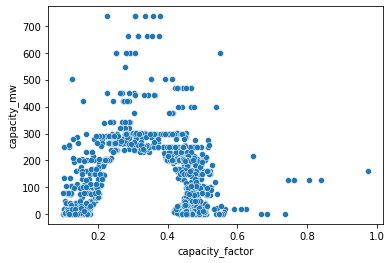

In [15]:
# df_all_concat.loc[mask,['generation_gwh', 'capacity_mw']]
sns.scatterplot(data=df_all_concat.loc[mask,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")

<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

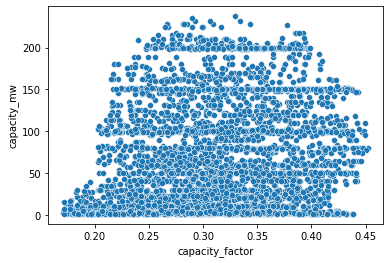

In [16]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']].drop(index_outliers, axis=0), x="capacity_factor", y="capacity_mw")


<AxesSubplot:xlabel='capacity_factor', ylabel='capacity_mw'>

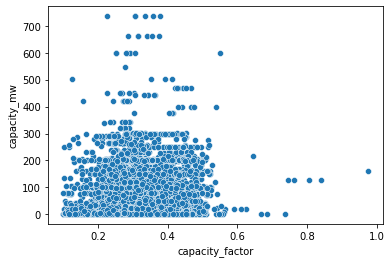

In [18]:
sns.scatterplot(data=df_all_concat.loc[:,['capacity_factor', 'capacity_mw']], x="capacity_factor", y="capacity_mw")


In [19]:
df_all_concat.drop(index_outliers, axis=0, inplace =True)

In [20]:
df_all_concat.drop(columns=['capacity_factor'], inplace = True)

In [21]:
df_all_concat.describe()

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_DWN,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLOUD_AMT_DAY,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,max_ALLSKY_SFC_SW_DNI,...,std_ALLSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_UP,std_ALLSKY_SFC_SW_UP_MAX,std_CLOUD_AMT_DAY,std_CLRSKY_SFC_SW_DNI,std_CLRSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_UP,std_T2M,capacity_mw,generation_gwh
count,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,...,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000
mean,5.209133,4.453503,0.792351,2.154728,53.514714,8.381875,5.673970,1.024865,11.352853,7.702446,...,1.855375,0.308830,0.467884,11.659225,1.222846,2.116488,0.342718,9.622597,69.165769,195.612571
std,1.176963,0.683614,0.197016,1.001683,11.288388,0.724739,0.437292,0.222179,4.558465,1.700791,...,0.256443,0.104223,0.267957,3.851373,0.404070,0.258933,0.127554,2.253654,62.433906,183.428547
min,2.700000,2.470000,0.180000,0.350000,23.330000,6.010000,3.570000,0.260000,-3.300000,3.840000,...,0.344000,0.024000,0.014000,3.901000,0.277000,0.637000,0.011000,0.930000,1.000000,1.571000
25%,4.340000,3.940000,0.670000,1.490000,45.150000,7.850000,5.360000,0.900000,7.980000,6.440000,...,1.690000,0.253000,0.309000,9.072000,0.926000,1.980000,0.279000,8.380000,10.500000,28.584000
50%,4.860000,4.190000,0.820000,1.830000,56.660000,8.280000,5.490000,1.050000,10.450000,7.540000,...,1.786000,0.296000,0.373000,10.583000,1.158000,2.153000,0.317000,10.002000,50.600000,147.623000
75%,6.020000,5.040000,0.940000,2.630000,61.030000,8.950000,6.060000,1.160000,14.940000,8.680000,...,1.985000,0.341000,0.535000,12.983000,1.451000,2.287000,0.372000,11.305000,109.500000,319.889000
max,8.010000,6.120000,1.320000,5.630000,81.690000,10.090000,6.990000,1.650000,25.200000,12.010000,...,2.534000,1.143000,1.511000,24.259000,4.002000,3.027000,1.299000,14.292000,237.500000,751.255000


# CORRELATION AND MUTUAL INFORMATION SCORES

## Avoid Multicollinearity

In [22]:
corr_matrix = df_all_concat.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

try:
    to_drop.remove('capacity_mw')
except ValueError:
    pass  # do nothing!
try:
    to_drop.remove('generation_gwh')
except ValueError:
    pass  # do nothing!

df_all_concat.drop(columns=to_drop, inplace=True)

## All Best K

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


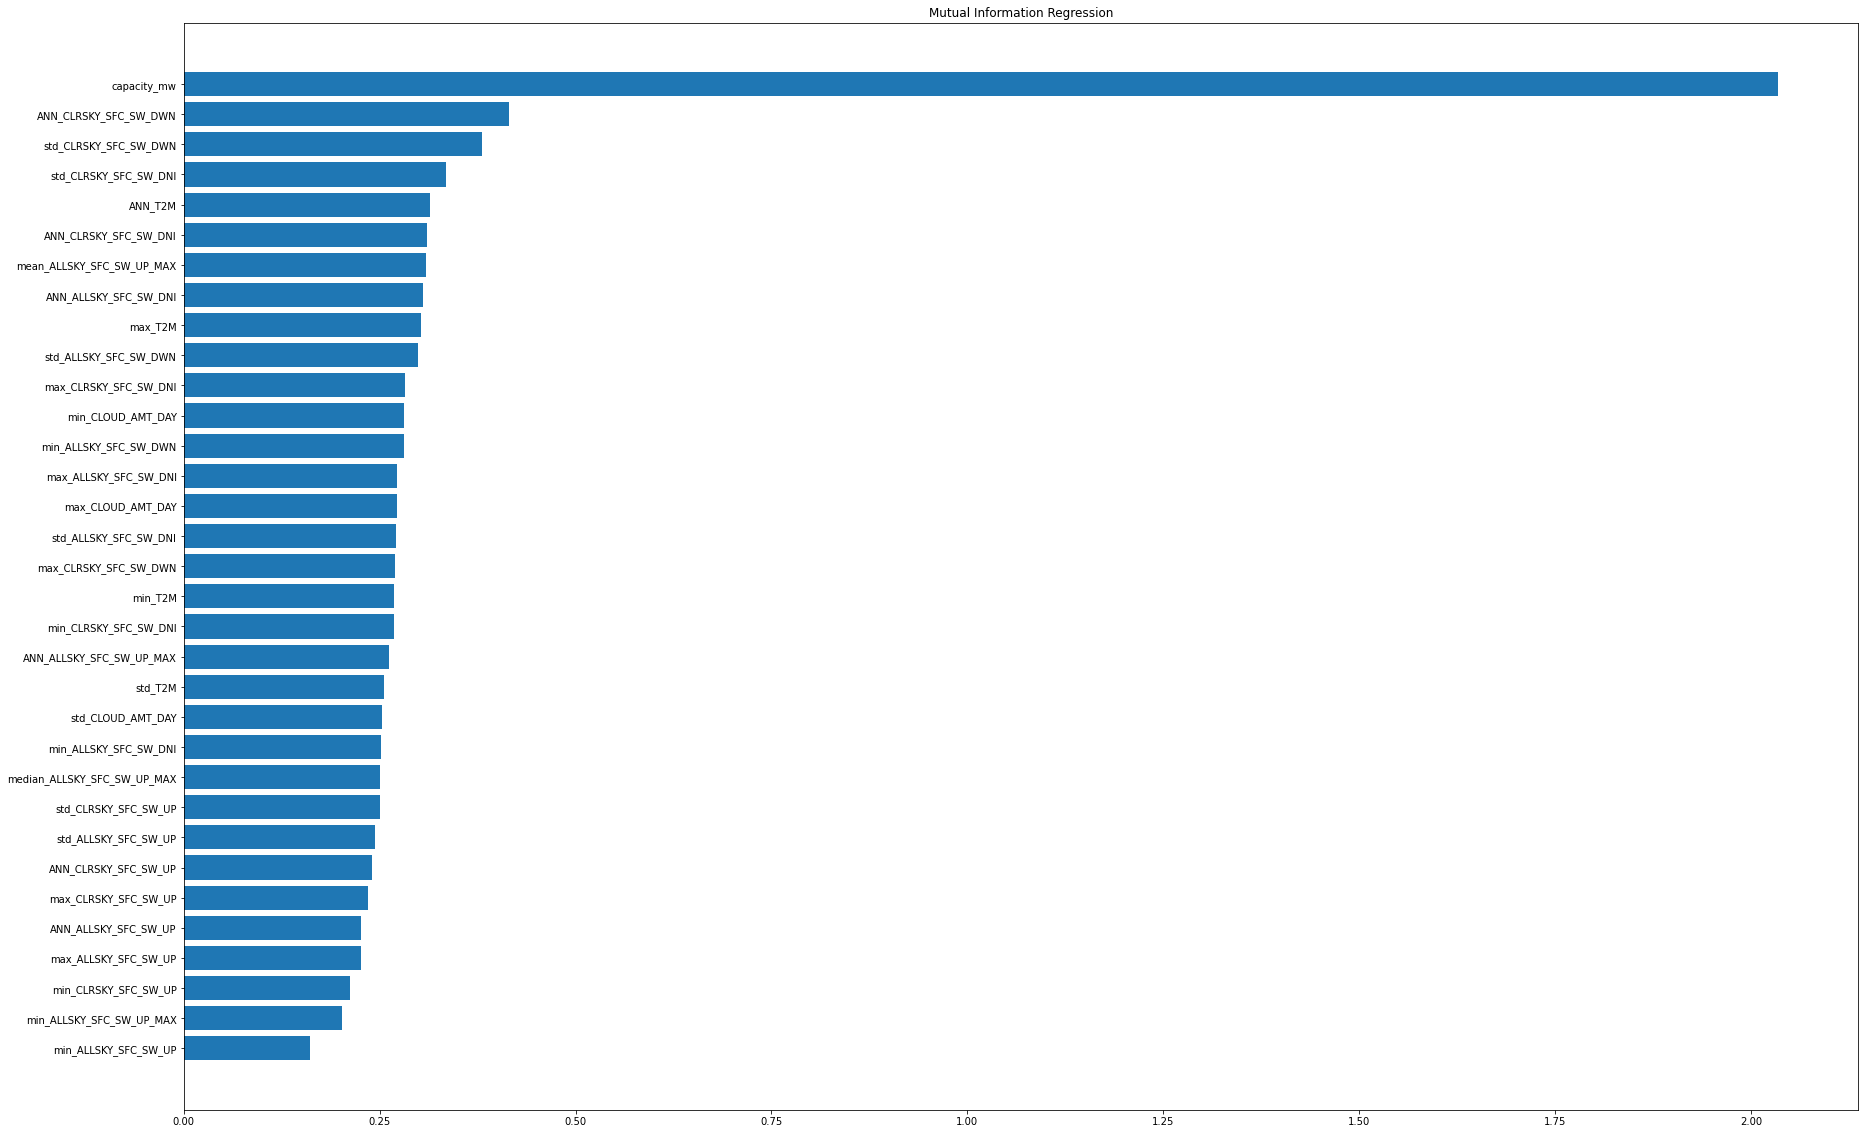

In [23]:
mi_scores = utils.make_mi_scores(df_all_concat.drop(columns=['generation_gwh']), df_all_concat[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

In [24]:
X = df_all_concat.drop(columns=['generation_gwh'])
# X = df_all_concat[['generation_gwh']]
y = df_all_concat['generation_gwh']
# y
selector = SelectKBest(mutual_info_regression, k= 10)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

df_all_concat_best_k_mi = pd.concat([features_df_new,y], axis=1)

## All Linear Correlations (Pearson) > 0.20 Dataset

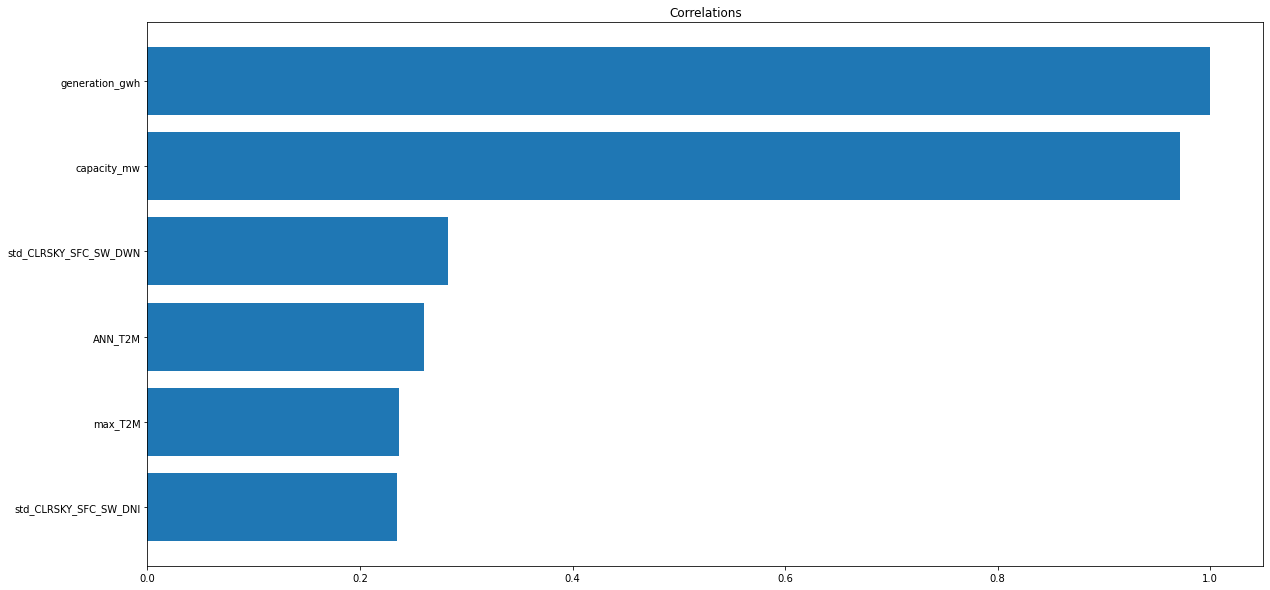

In [25]:

corr_matrix = df_all_concat.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [26]:
df_all_concat_lin_corr = df_all_concat[target_correlations[target_correlations > .20].index]
df_all_concat_lin_corr

,generation_gwh,capacity_mw,std_CLRSKY_SFC_SW_DWN,ANN_T2M,max_T2M,std_CLRSKY_SFC_SW_DNI
1,15.761667,9.9,2.204,13.67,23.41,1.550
2,250.443889,65.0,2.533,14.32,17.87,2.142
3,119.899722,46.0,2.440,14.74,19.69,2.057
4,354.079167,140.0,2.282,13.48,23.30,1.575
5,177.613889,66.0,2.299,17.09,20.67,1.862
...,...,...,...,...,...,...
5798,2.892000,1.3,2.164,6.80,21.59,1.187
5799,4.839000,1.5,2.088,9.33,24.23,1.081
5800,171.358000,64.5,2.377,6.40,21.72,1.672
5804,63.278000,21.0,2.315,10.90,27.19,1.603


In [27]:
df_all_concat_lin_corr.columns

Index(['generation_gwh', 'capacity_mw', 'std_CLRSKY_SFC_SW_DWN', 'ANN_T2M',
       'max_T2M', 'std_CLRSKY_SFC_SW_DNI'],
      dtype='object')

## Annual Dataset

In [28]:
corr_matrix

,ANN_ALLSKY_SFC_SW_DNI,ANN_ALLSKY_SFC_SW_UP,ANN_ALLSKY_SFC_SW_UP_MAX,ANN_CLRSKY_SFC_SW_DNI,ANN_CLRSKY_SFC_SW_DWN,ANN_CLRSKY_SFC_SW_UP,ANN_T2M,max_ALLSKY_SFC_SW_DNI,max_ALLSKY_SFC_SW_UP,max_CLOUD_AMT_DAY,...,std_ALLSKY_SFC_SW_DNI,std_ALLSKY_SFC_SW_DWN,std_ALLSKY_SFC_SW_UP,std_CLOUD_AMT_DAY,std_CLRSKY_SFC_SW_DNI,std_CLRSKY_SFC_SW_DWN,std_CLRSKY_SFC_SW_UP,std_T2M,capacity_mw,generation_gwh
ANN_ALLSKY_SFC_SW_DNI,1.000000,0.541293,0.221293,0.821410,0.808697,0.226956,0.677720,0.801668,0.144242,0.776999,...,0.289605,0.183588,0.044108,0.275572,0.080455,0.357770,0.158454,0.472709,0.093855,0.085118
ANN_ALLSKY_SFC_SW_UP,0.541293,1.000000,0.545362,0.560438,0.417580,0.934108,0.092153,0.392118,0.801289,0.514171,...,0.002132,0.025613,0.627897,0.016884,0.159718,0.128276,0.540489,0.255990,0.058780,0.075923
ANN_ALLSKY_SFC_SW_UP_MAX,0.221293,0.545362,1.000000,0.091858,0.266811,0.718692,0.494628,0.192535,0.748644,0.071787,...,0.195423,0.101306,0.672306,0.189457,0.060310,0.190128,0.762873,0.625591,0.086867,0.065102
ANN_CLRSKY_SFC_SW_DNI,0.821410,0.560438,0.091858,1.000000,0.641573,0.353782,0.327696,0.806944,0.230401,0.515623,...,0.472704,0.414809,0.143114,0.329350,0.249689,0.041113,0.001091,0.340666,0.029204,0.043434
ANN_CLRSKY_SFC_SW_DWN,0.808697,0.417580,0.266811,0.641573,1.000000,0.163800,0.815146,0.488746,0.003076,0.718613,...,0.041878,0.201317,0.133969,0.031252,0.434070,0.691034,0.271238,0.558487,0.179823,0.179874
ANN_CLRSKY_SFC_SW_UP,0.226956,0.934108,0.718692,0.353782,0.163800,1.000000,0.190120,0.158042,0.851733,0.258438,...,0.073462,0.011061,0.685799,0.090141,0.138621,0.022911,0.679515,0.494651,0.018153,0.037308
ANN_T2M,0.677720,0.092153,0.494628,0.327696,0.815146,0.190120,1.000000,0.400222,0.253051,0.599785,...,0.015684,0.196359,0.295256,0.108167,0.383831,0.742499,0.469517,0.717470,0.258035,0.260491
max_ALLSKY_SFC_SW_DNI,0.801668,0.392118,0.192535,0.806944,0.488746,0.158042,0.400222,1.000000,0.128315,0.390113,...,0.746995,0.644451,0.124805,0.667454,0.360371,0.077466,0.083384,0.409195,0.004685,0.027379
max_ALLSKY_SFC_SW_UP,0.144242,0.801289,0.748644,0.230401,0.003076,0.851733,0.253051,0.128315,1.000000,0.156589,...,0.003822,0.041397,0.919340,0.022089,0.005791,0.123796,0.875776,0.445951,0.031492,0.017314
max_CLOUD_AMT_DAY,0.776999,0.514171,0.071787,0.515623,0.718613,0.258438,0.599785,0.390113,0.156589,1.000000,...,0.247677,0.262850,0.011907,0.277074,0.363343,0.529676,0.117506,0.275409,0.114074,0.133831


In [29]:

columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('ANN') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_annual = df_all_concat.loc[:,columns_keep]

corr_matrix = df_all_concat_annual.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


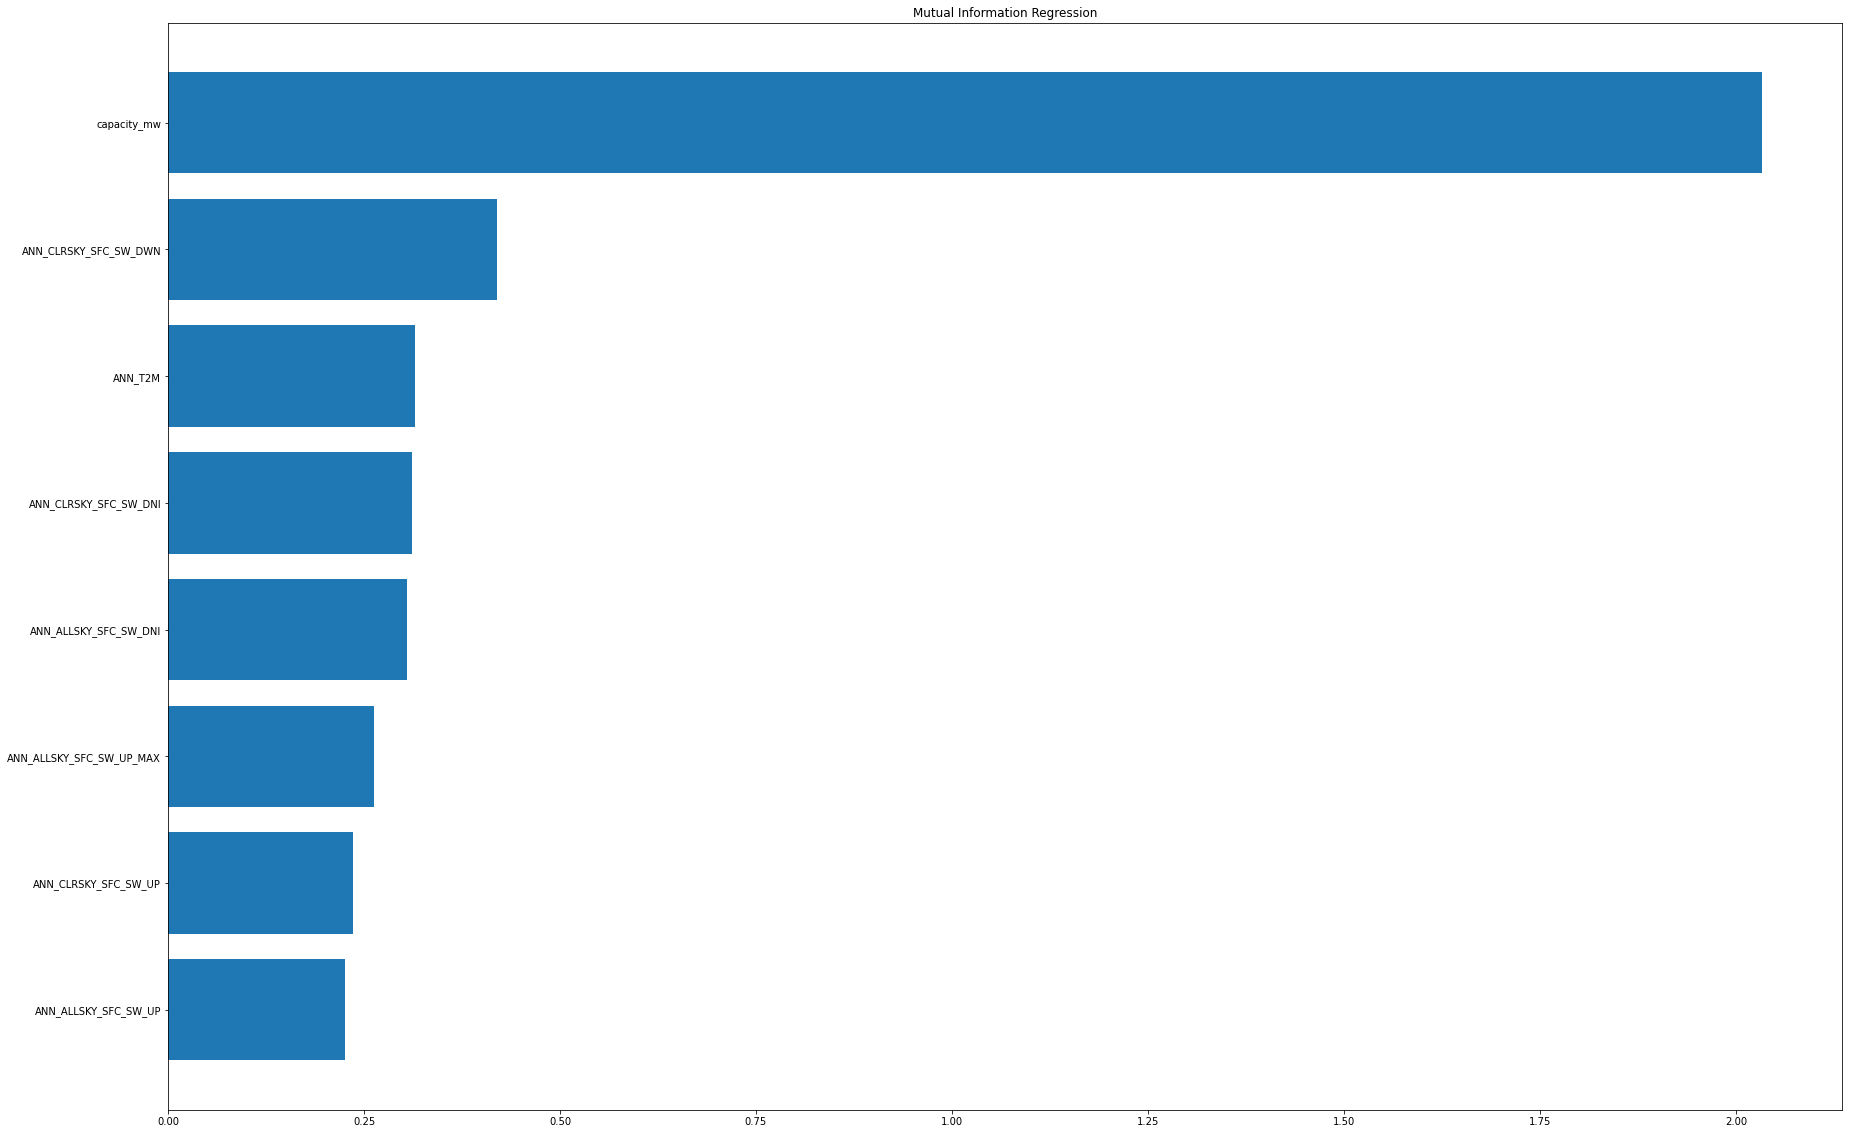

In [30]:
mi_scores = utils.make_mi_scores(df_all_concat_annual.drop(columns=['generation_gwh']), df_all_concat_annual[['generation_gwh']], "regression")

plt.figure(figsize=(30,20))
utils.plot_scores(mi_scores, "Mutual Information Regression")

## Annual Linear Correlations (Pearson) > 0.20 Dataset

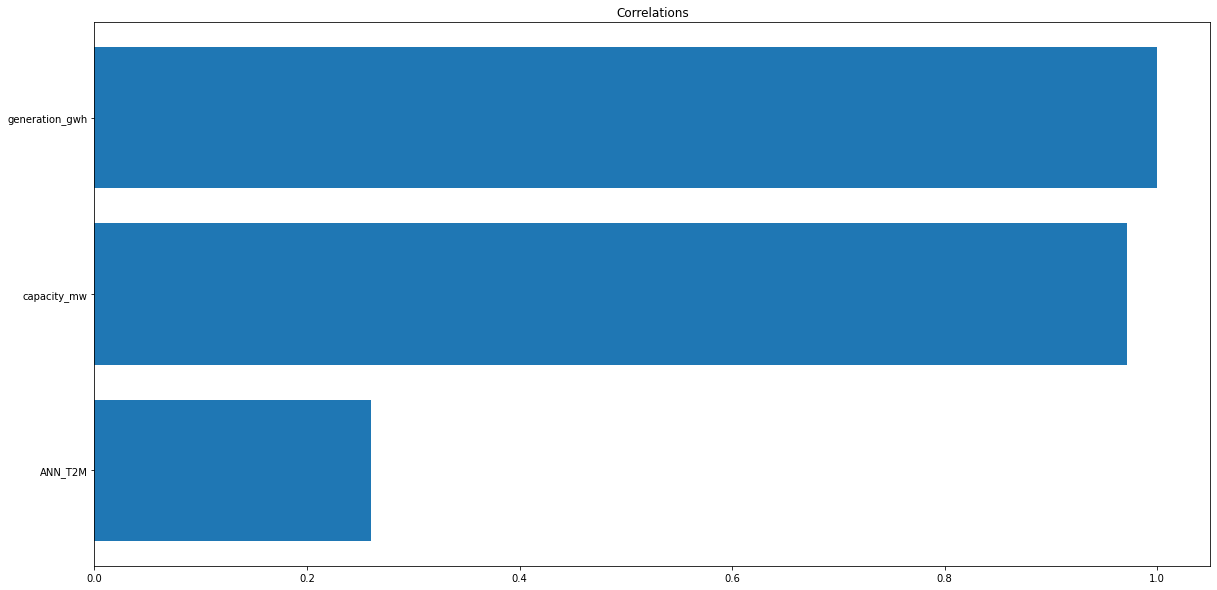

In [34]:
corr_matrix = df_all_concat_annual.corr().abs()

target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [35]:
df_all_concat_annual_lin_corr = df_all_concat_annual[target_correlations[target_correlations > .20].index]
df_all_concat_annual_lin_corr

,generation_gwh,capacity_mw,ANN_T2M
1,15.761667,9.9,13.67
2,250.443889,65.0,14.32
3,119.899722,46.0,14.74
4,354.079167,140.0,13.48
5,177.613889,66.0,17.09
...,...,...,...
5798,2.892000,1.3,6.80
5799,4.839000,1.5,9.33
5800,171.358000,64.5,6.40
5804,63.278000,21.0,10.90


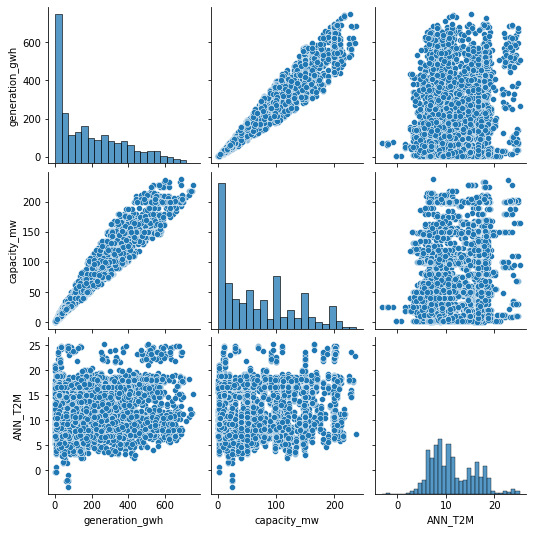

In [36]:
# g = sns.PairGrid(df_all_concat_annual_lin_corr)
# g.map(sns.scatterplot)

sns.pairplot(df_all_concat_annual_lin_corr)

## Only Capacity

In [39]:
columns_keep = df_all_concat.columns.str.contains('generation_gwh') | df_all_concat.columns.str.contains('capacity_mw')
df_all_concat_only_capacity = df_all_concat.loc[:,columns_keep]
df_all_concat_only_capacity

,capacity_mw,generation_gwh
1,9.9,15.761667
2,65.0,250.443889
3,46.0,119.899722
4,140.0,354.079167
5,66.0,177.613889
...,...,...
5798,1.3,2.892000
5799,1.5,4.839000
5800,64.5,171.358000
5804,21.0,63.278000


# X AND Y

In [41]:
dataframes_dict_X_y = {
    'df_all_concat_annual_lin_corr' : {},
    'df_all_concat_lin_corr': {},
    'df_all_concat_best_k_mi': {},
    'df_all_concat': {},
    'df_all_concat_only_capacity': {}
}


In [42]:
iso_df_all_concat_annual_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_annual_lin_corr.fit_predict(df_all_concat_annual_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_annual_lin_corr[mask].index
df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat_annual_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_annual_lin_corr['generation_gwh']



dataframes_dict_X_y['df_all_concat_annual_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_annual_lin_corr']['y'] = y

/tmp/ipykernel_288/2987193366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_annual_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [43]:
iso_df_all_concat_lin_corr = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_lin_corr.fit_predict(df_all_concat_lin_corr)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_lin_corr[mask].index
df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_lin_corr.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_lin_corr['generation_gwh']

dataframes_dict_X_y['df_all_concat_lin_corr']['X'] = X
dataframes_dict_X_y['df_all_concat_lin_corr']['y'] = y

/tmp/ipykernel_288/2728832043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_concat_lin_corr.drop(index_outliers, axis=0, inplace =True)


In [46]:
iso_df_all_concat_best_k_mi = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat_best_k_mi.fit_predict(df_all_concat_best_k_mi)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat_best_k_mi[mask].index
df_all_concat_best_k_mi.drop(index_outliers, axis=0, inplace =True)


X = df_all_concat_best_k_mi.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_best_k_mi['generation_gwh']


dataframes_dict_X_y['df_all_concat_best_k_mi']['X'] = X
dataframes_dict_X_y['df_all_concat_best_k_mi']['y'] = y

In [47]:
iso_df_all_concat = IsolationForest(max_samples='auto',contamination='auto')
yhat = iso_df_all_concat.fit_predict(df_all_concat)
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_all_concat[mask].index
df_all_concat.drop(index_outliers, axis=0, inplace =True)

X = df_all_concat.drop(columns=['generation_gwh'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_all_concat['generation_gwh']


dataframes_dict_X_y['df_all_concat']['X'] = X
dataframes_dict_X_y['df_all_concat']['y'] = y

In [48]:
X = df_all_concat_only_capacity[['capacity_mw']]
X.reindex(sorted(X.columns), axis=1)
y = df_all_concat_only_capacity['generation_gwh']

dataframes_dict_X_y['df_all_concat_only_capacity']['X'] = X
dataframes_dict_X_y['df_all_concat_only_capacity']['y'] = y

In [53]:
for i, df_X_y in dataframes_dict_X_y.items():
    list_train_test_split = train_test_split(df_X_y['X'], df_X_y['y'], test_size=0.2,random_state = 0)
    dataframes_dict_X_y[i]['X_train'] = list_train_test_split[0]
    dataframes_dict_X_y[i]['X_test'] = list_train_test_split[1]
    dataframes_dict_X_y[i]['y_train'] = list_train_test_split[2]
    dataframes_dict_X_y[i]['y_test'] = list_train_test_split[3]

# DECISION TREE REGRESSOR

df_all_concat_annual_lin_corr best_tree_size: 500
df_all_concat_lin_corr best_tree_size: 50
df_all_concat_best_k_mi best_tree_size: 80
df_all_concat best_tree_size: 50
df_all_concat_only_capacity best_tree_size: 500


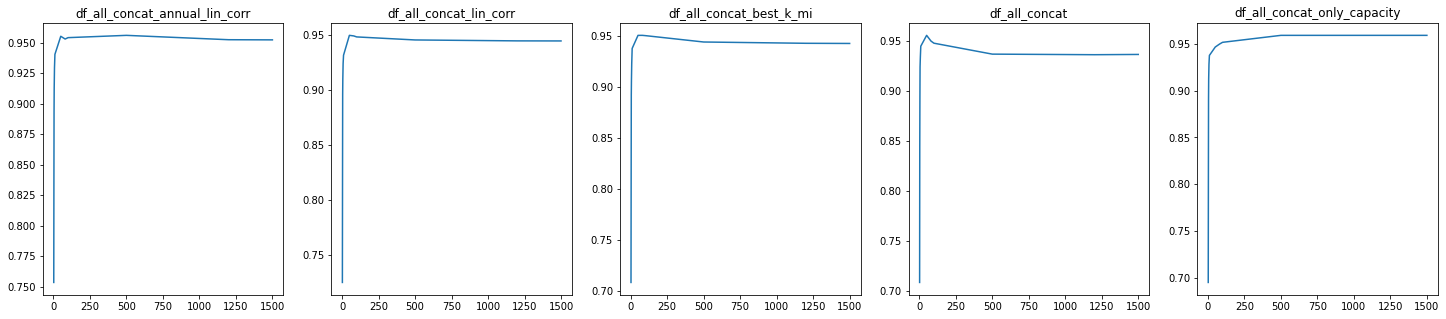

In [55]:
candidate_max_leaf_nodes = [2, 3, 4, 5, 7, 10, 50, 80, 100, 500, 1200, 1500]

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(25,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_tree("regression",node, df_X_y['X_train'], df_X_y['X_test'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_max_leaf_nodes}
    best_tree_size = max(results, key=results.get)
    print(f'{k} best_tree_size: {best_tree_size}')
    dataframes_dict_X_y[k]['best_tree_size'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])

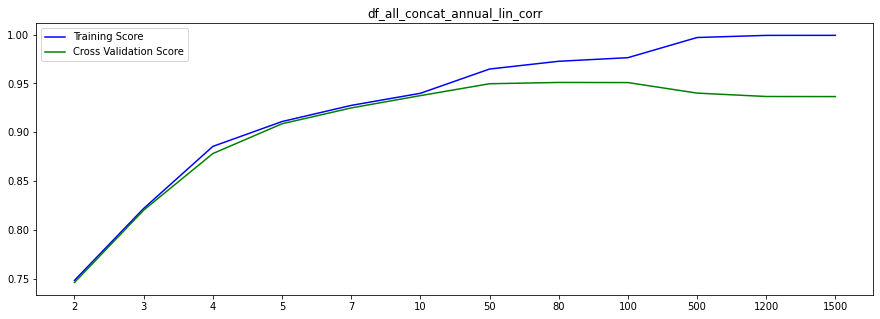

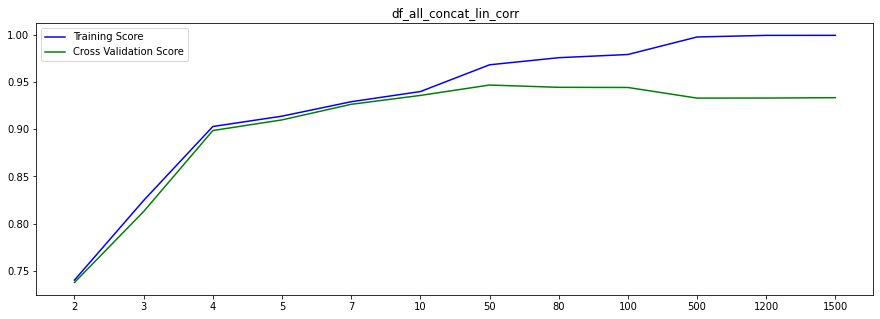

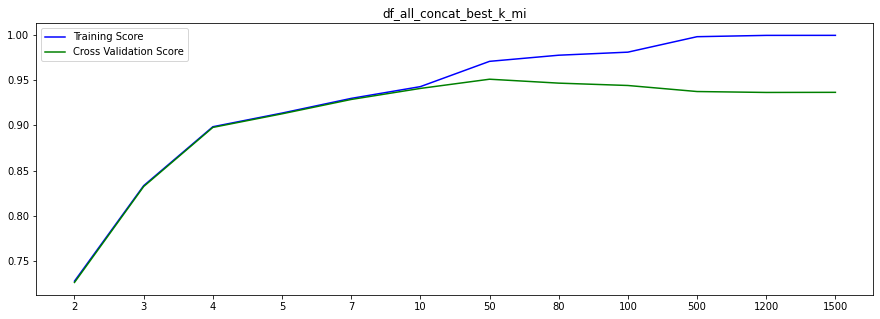

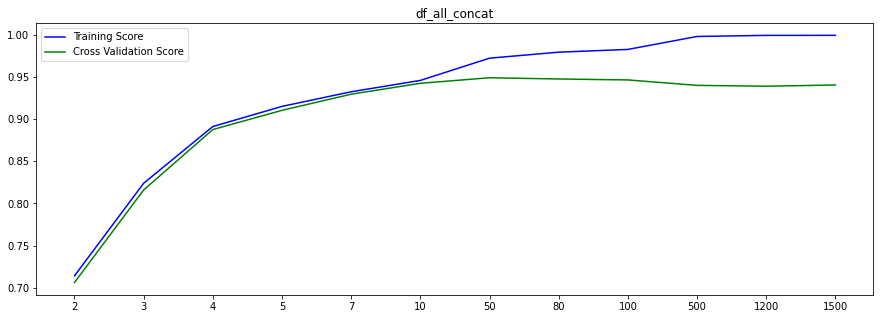

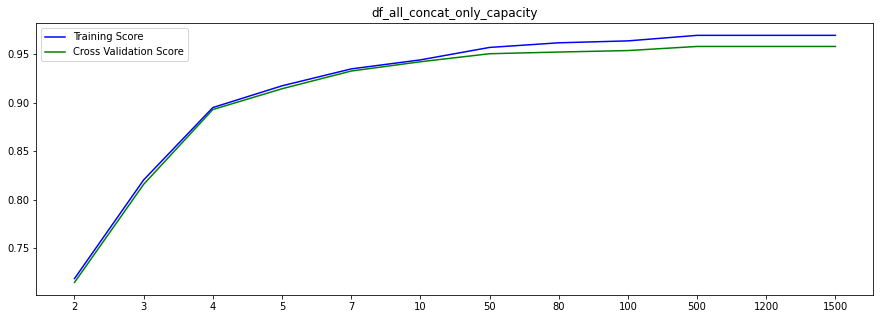

In [56]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, DecisionTreeRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'max_leaf_nodes', np.array(candidate_max_leaf_nodes))

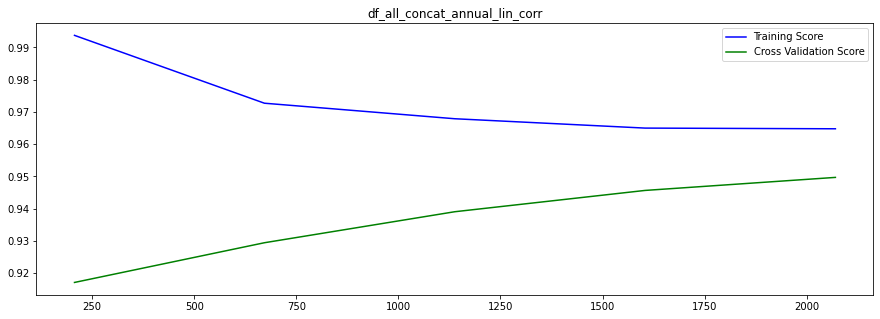

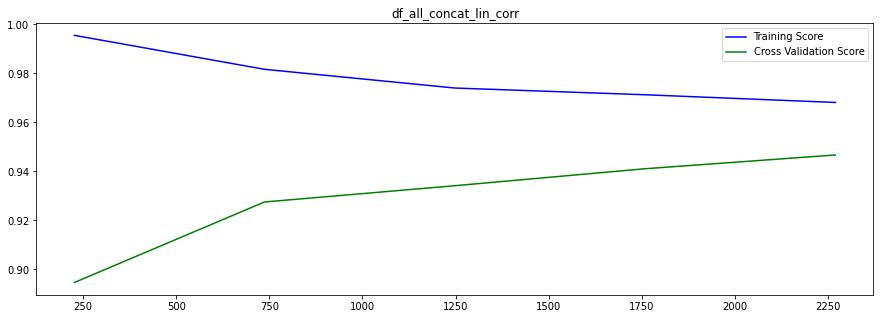

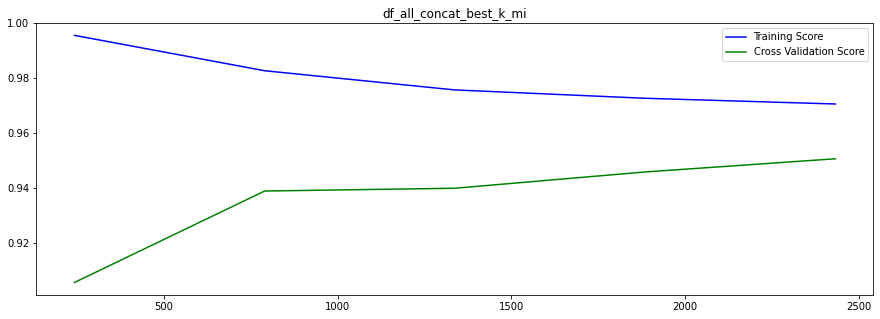

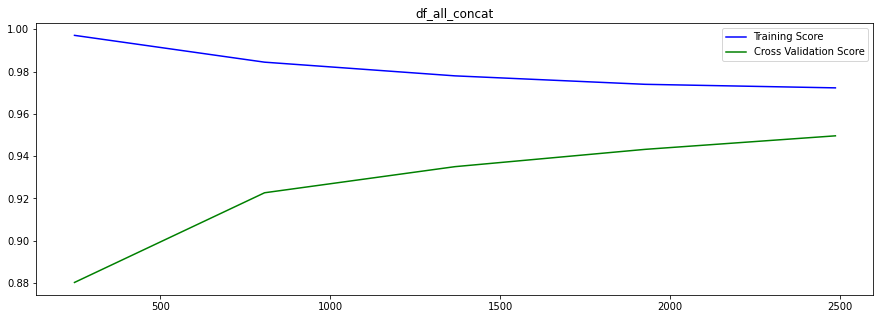

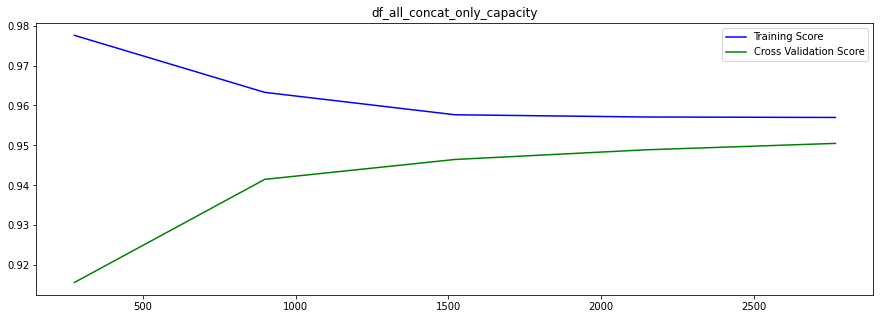

In [57]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, DecisionTreeRegressor(max_leaf_nodes=50),df_X_y['X_train'], df_X_y['y_train'])

In [58]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], DecisionTreeRegressor(max_leaf_nodes=50), k)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9496525477782868, 'test_mean_squared_error': 802.1826491405756, 'test_mean_absolute_error': 17.66113707543179, 'test_root_mean_squared_error': 28.313068117537263}
df_all_concat_lin_corr
{'test_r2': 0.9467308196776372, 'test_mean_squared_error': 1165.502508927943, 'test_mean_absolute_error': 21.062456269296526, 'test_root_mean_squared_error': 34.083356978439426}
df_all_concat_best_k_mi
{'test_r2': 0.9506189644558063, 'test_mean_squared_error': 1360.3459708120076, 'test_mean_absolute_error': 23.13733316122986, 'test_root_mean_squared_error': 36.87345970154525}
df_all_concat
{'test_r2': 0.9498234921457677, 'test_mean_squared_error': 1592.197900518213, 'test_mean_absolute_error': 25.018678600568045, 'test_root_mean_squared_error': 39.88557586044982}
df_all_concat_only_capacity
{'test_r2': 0.9504980498338762, 'test_mean_squared_error': 1674.8545745834513, 'test_mean_absolute_error': 26.173503169811607, 'test_root_mean_squared_error': 40.9024480556

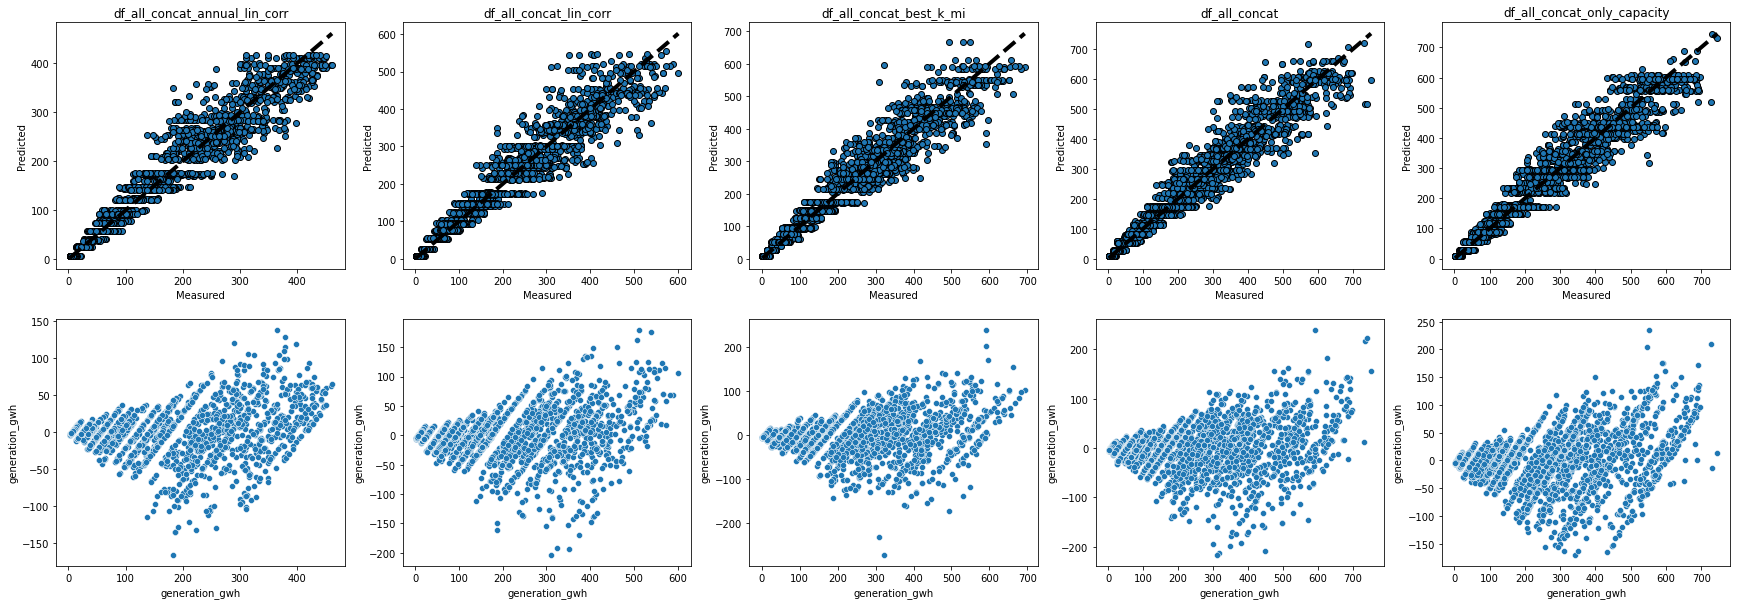

In [59]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(DecisionTreeRegressor(max_leaf_nodes=50), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(max_leaf_nodes = 50)

# Fit model
tree_model.fit(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['y_train'])
y_pred = tree_model.predict(dataframes_dict_X_y['df_all_concat_annual_best_k_mi']['X_test'])

# RANDOM FOREST REGRESSOR

In [79]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [80]:

# rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid, n_iter = 40, cv=5, verbose = 2, n_jobs=4)

In [81]:
rf_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=330, max_leaf_nodes=110, min_samples_leaf=15, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=330, max_leaf_nodes=110, min_samples_leaf=15, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=330, max_leaf_nodes=110, min_samples_leaf=15, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=330, max_leaf_nodes=110, min_samples_leaf=15, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=330, max_leaf_nodes=110, min_samples_leaf=15, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=400, max_leaf_nodes=240, min_samples_leaf=35, min_samples_split=30, n_estimators=90; total time=   0.7s
[CV] END bootstrap=True, max_depth=400, max_leaf_nodes=240, min_samples_leaf=35, min_samples_split=30, n

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=40, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290, 300, ...],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110, 120, 130, 140,
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [82]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=180, max_leaf_nodes=350, min_samples_leaf=5,
                      min_samples_split=10)

In [83]:
rf_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

0.9635112925865504

In [84]:
rf_model = RandomForestRegressor(max_depth=180, max_leaf_nodes=350, min_samples_leaf=5,
                      min_samples_split=10)
# rf_model = RandomForestRegressor()
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):

    # results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_model, k)
    # print(df_X_y)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9561457628549412, 'test_mean_squared_error': 699.4761056458257, 'test_mean_absolute_error': 15.892050905147707, 'test_root_mean_squared_error': 26.428904525208207}
df_all_concat_lin_corr
{'test_r2': 0.9585446091220098, 'test_mean_squared_error': 906.3304409884977, 'test_mean_absolute_error': 18.05247191668291, 'test_root_mean_squared_error': 30.065012603556333}
df_all_concat_best_k_mi
{'test_r2': 0.9620073007134357, 'test_mean_squared_error': 1046.7560880112628, 'test_mean_absolute_error': 19.385619880732133, 'test_root_mean_squared_error': 32.347071184467055}
df_all_concat
{'test_r2': 0.9627595648864297, 'test_mean_squared_error': 1183.337087788289, 'test_mean_absolute_error': 20.953120167207295, 'test_root_mean_squared_error': 34.37025837984605}
df_all_concat_only_capacity
{'test_r2': 0.9527393746254414, 'test_mean_squared_error': 1600.8897878868079, 'test_mean_absolute_error': 24.762925163408596, 'test_root_mean_squared_error': 39.97825736

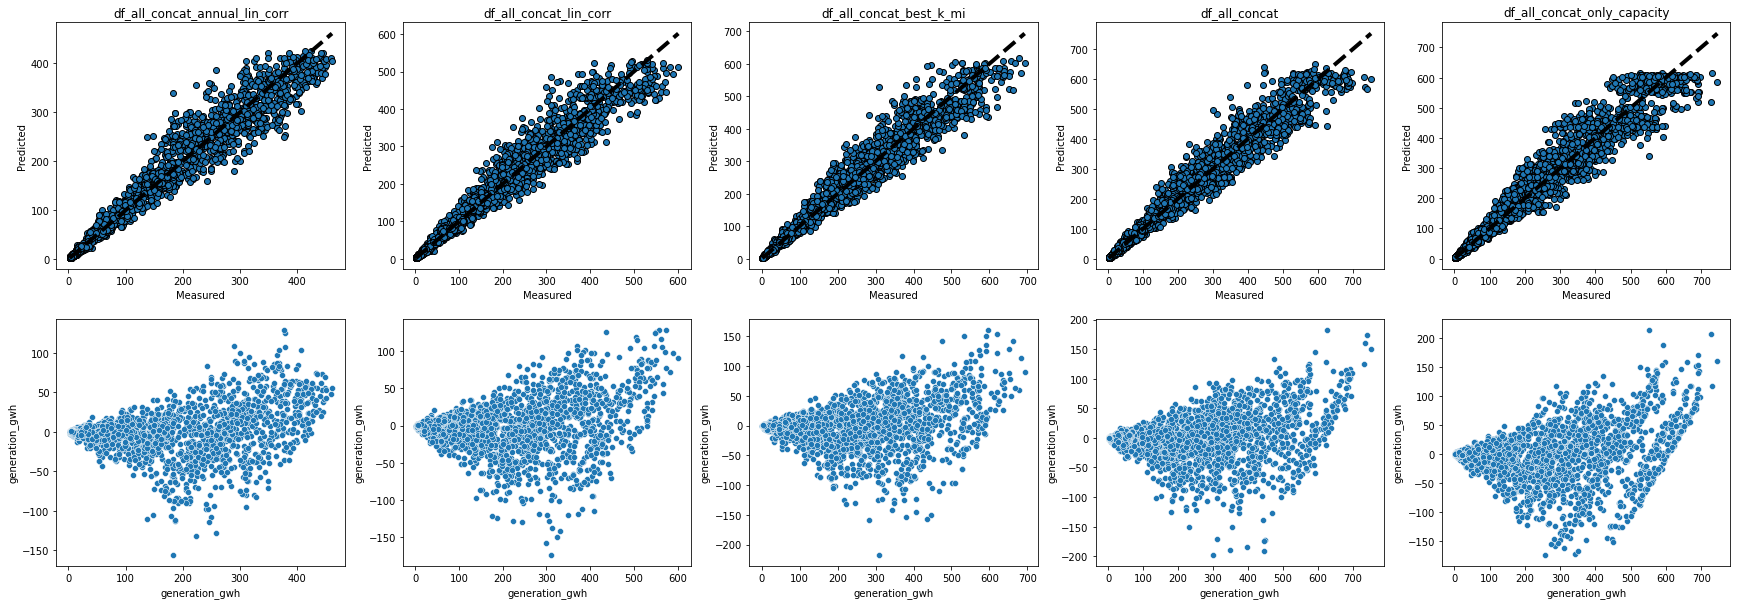

In [85]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(rf_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()
    
    residuals = df_X_y['y_train'] - predicted
    dataframes_dict_X_y[k]['predictions'] = predicted
    dataframes_dict_X_y[k]['residuals'] = residuals
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

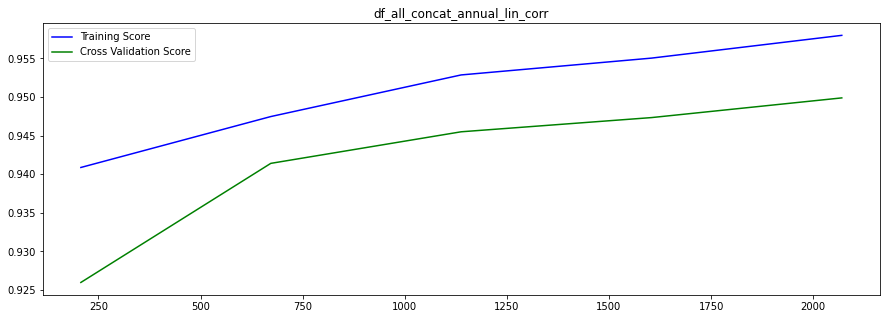

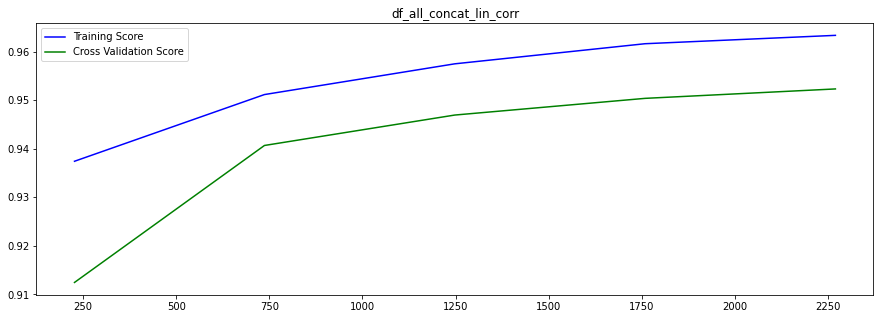

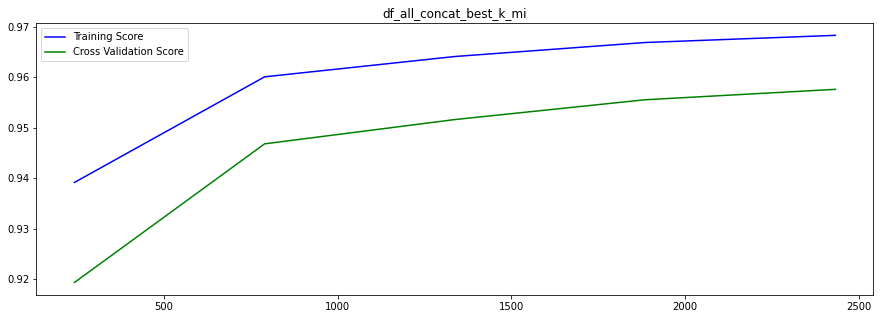

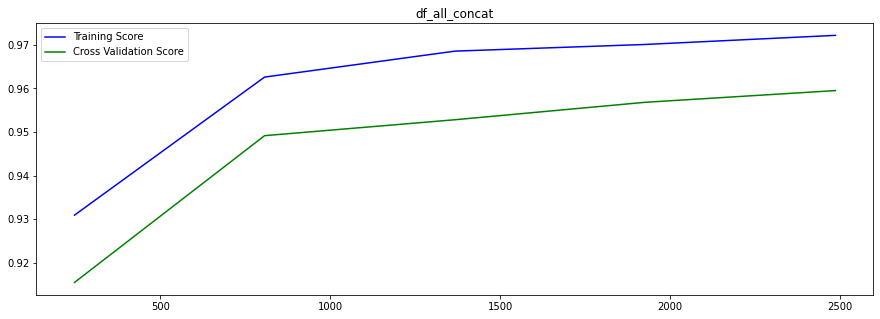

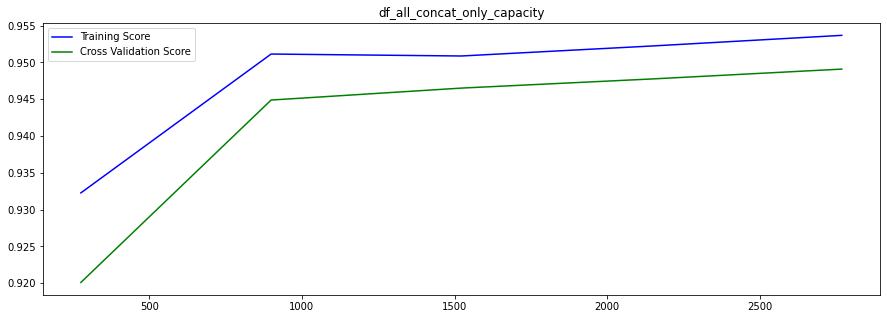

In [62]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, rf_model,df_X_y['X_train'], df_X_y['y_train'])

# LASSO, RIDGE, LINEAR REGRESSION

In [64]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

ridge_model = Ridge(alpha=1)
ridge_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

linreg_model = LinearRegression()
linreg_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'],dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

y_pred = lasso_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Lasso")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(lasso_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

y_pred = linreg_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Linear Regression")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(linreg_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
)
y_pred = ridge_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
print("Ridge")
print(mean_absolute_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(mean_squared_error(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], y_pred))
print(ridge_model.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']))

Lasso
24.840599427700152
1458.116627285523
0.9339092226355474
Linear Regression
24.857982422285826
1458.262083379857
0.9339026296743487
Ridge
24.840870804928663
1458.0956129370586
0.933910175134545


In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Lasso(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])


In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(Ridge(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(LinearRegression(), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

# SCALLING

In [65]:

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):    
    # X_train_normalized = stats.boxcox(X_train)
    x = df_X_y['X_train'].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    power_transformer = PowerTransformer(method='yeo-johnson')
    standard_scaler = StandardScaler()
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_train_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_train'].index, columns=df_X_y['X_train'].columns)

    x = df_X_y['X_test'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_test_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X_test'].index, columns=df_X_y['X_test'].columns)

    x = df_X_y['X'].values #returns a numpy array
    # x_scaled = min_max_scaler.fit_transform(x)
    # x_scaled = power_transformer.fit_transform(x)
    x_scaled = standard_scaler.fit_transform(x)
    df_X_y['X_scaled'] = pd.DataFrame(x_scaled, index=df_X_y['X'].index, columns=df_X_y['X'].columns)


# KNN

df_all_concat_annual_lin_corr best_n_neighbors: 27
df_all_concat_lin_corr best_n_neighbors: 9
df_all_concat_best_k_mi best_n_neighbors: 9
df_all_concat best_n_neighbors: 3
df_all_concat_only_capacity best_n_neighbors: 30


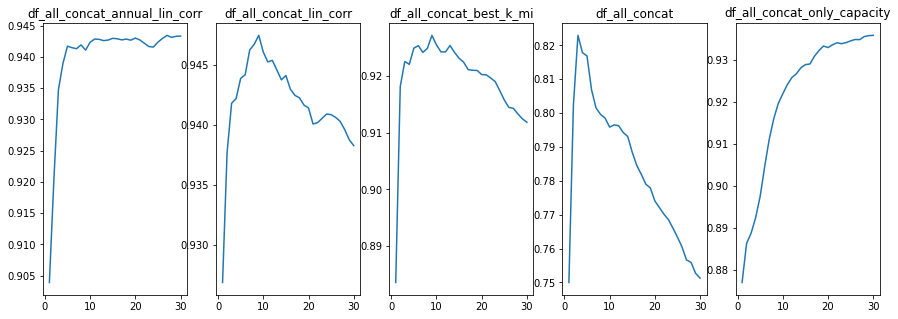

In [66]:
candidate_n_neighbors = np.arange(1,31)

# plt.figure(figsize=(25,15))
fig, ax =plt.subplots(1,len(dataframes_dict_X_y), figsize=(15,5))
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    results = {}
    results = {node: utils.get_accuracy_knn("regression",node, df_X_y['X_train_scaled'], df_X_y['X_test_scaled'], df_X_y['y_train'], df_X_y['y_test']) for node in candidate_n_neighbors}
    best_n_neighbors = max(results, key=results.get)
    print(f'{k} best_n_neighbors: {best_n_neighbors}')
    dataframes_dict_X_y[k]['best_n_neighbors'] = best_tree_size
    ax[i].set_title(k)
    sns.lineplot(data=results, x= results.keys(), y= results.values(), ax=ax[i])


# POLYNOMIAL FEATURES

In [67]:
polynomial_features = PolynomialFeatures(2)
polynomial_features.fit_transform(X)

array([[1.00000e+00, 9.90000e+00, 9.80100e+01],
       [1.00000e+00, 6.50000e+01, 4.22500e+03],
       [1.00000e+00, 4.60000e+01, 2.11600e+03],
       ...,
       [1.00000e+00, 6.45000e+01, 4.16025e+03],
       [1.00000e+00, 2.10000e+01, 4.41000e+02],
       [1.00000e+00, 4.50000e+00, 2.02500e+01]])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh', ylabel='generation_gwh'>

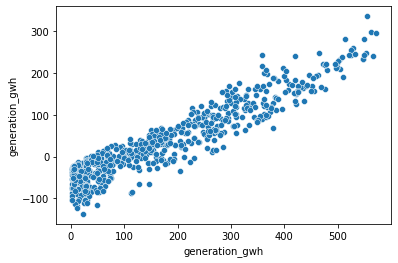

In [68]:
model_scaled_poly_knn = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2),
    KNeighborsRegressor(n_neighbors = dataframes_dict_X_y['df_all_concat_lin_corr']['best_n_neighbors'])
)

model_scaled_poly_knn.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
model_scaled_poly_knn.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'] - y_pred
# ap_residuals = np.abs(residuals) / y_test
# lap_residuals = np.log(ap_residuals)

y_pred = model_scaled_poly_knn.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
sns.scatterplot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], residuals)

In [69]:
results = cross_validate(KNeighborsRegressor(n_neighbors = 12), X, y, cv=5)
results

{'fit_time': array([0.00441909, 0.00766253, 0.00330424, 0.00386548, 0.00578904]),
 'score_time': array([0.00605559, 0.00630069, 0.00794387, 0.00987482, 0.00785971]),
 'test_score': array([0.9532533 , 0.95421516, 0.94871883, 0.94941298, 0.94889446])}

# VALIDATION AND LEARNING CURVE
https://scikit-learn.org/stable/modules/learning_curve.html

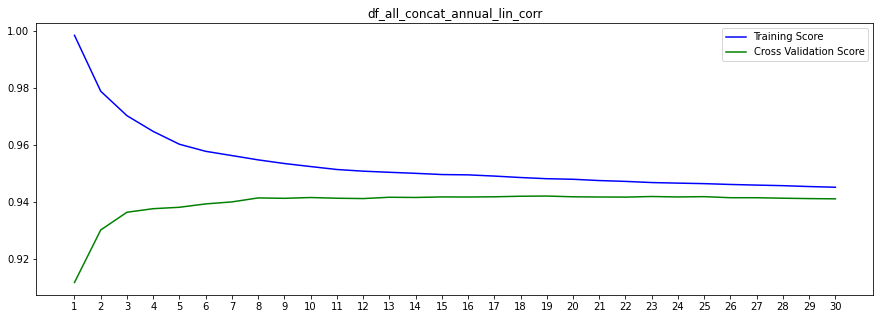

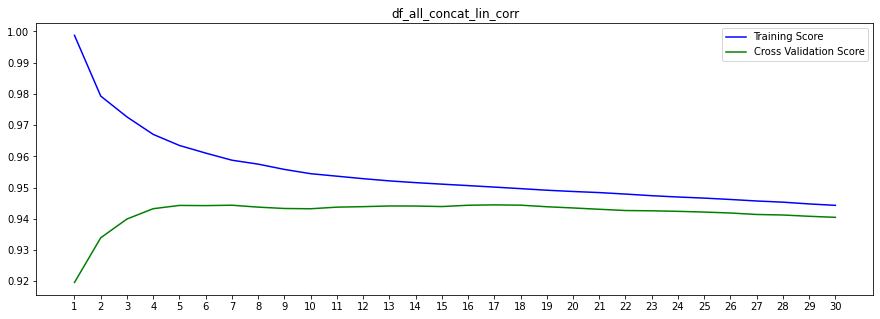

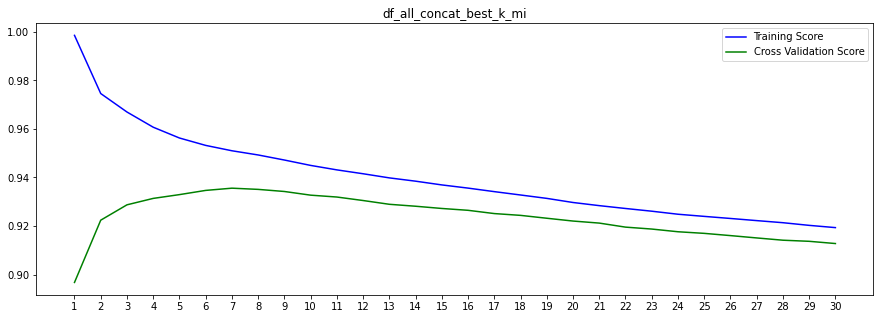

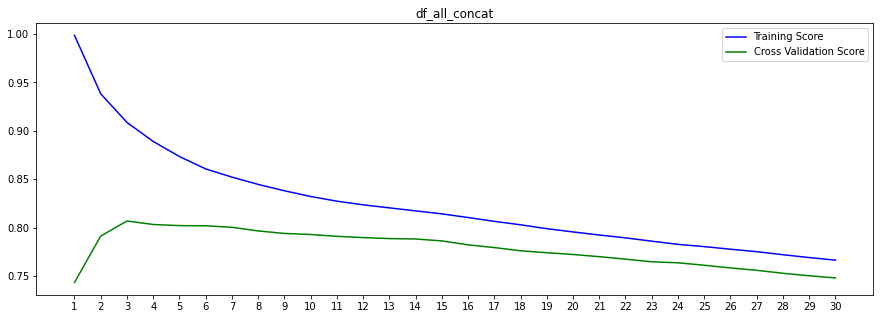

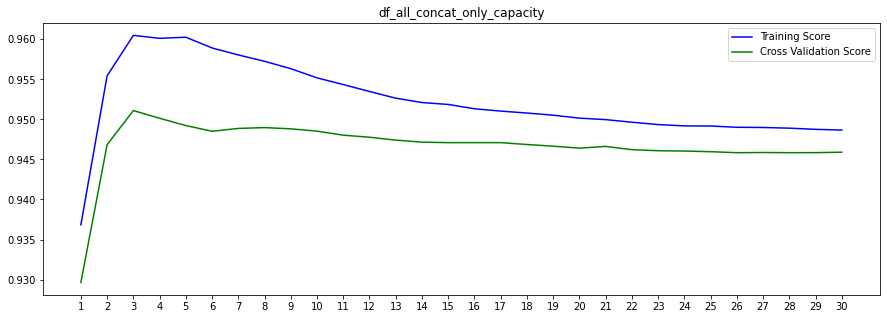

In [70]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train_scaled'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

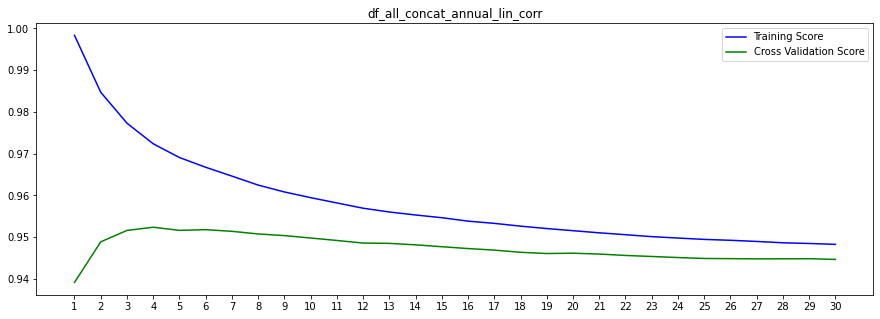

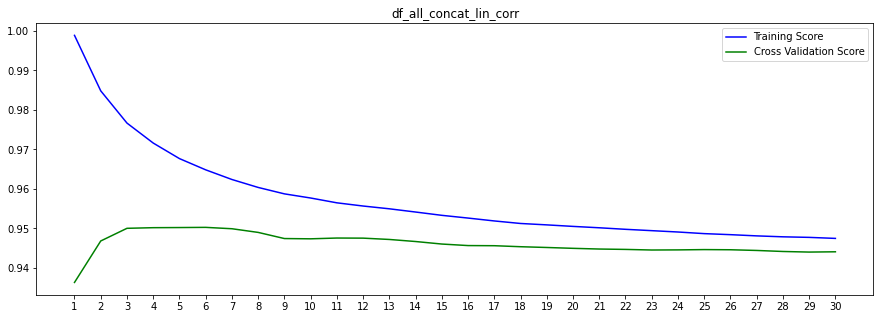

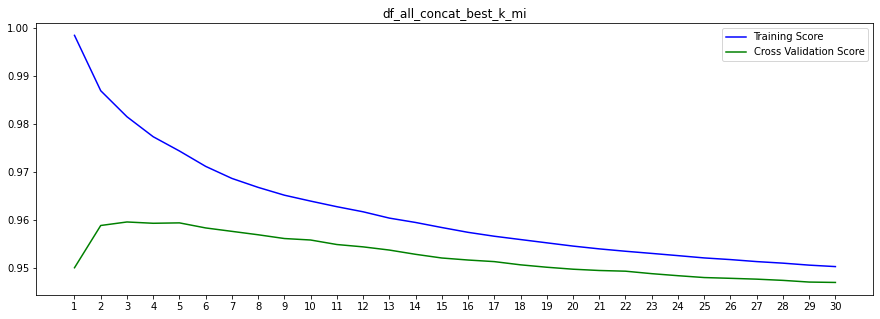

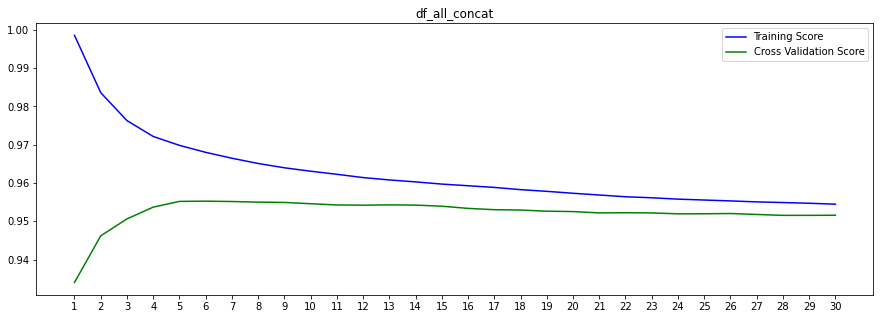

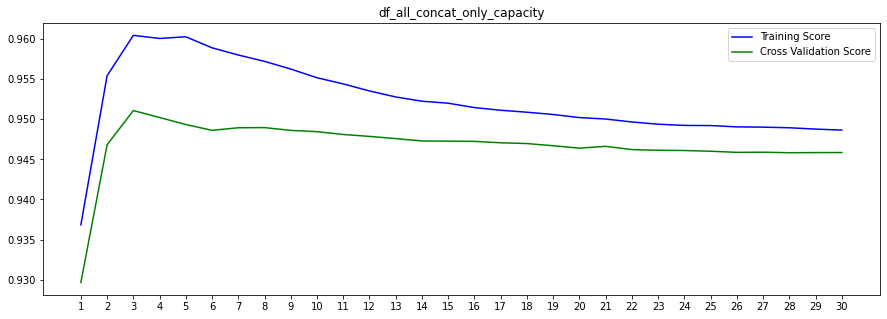

In [74]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.validation_curve_plot(k, KNeighborsRegressor(), df_X_y['X_train'], df_X_y['y_train'], 'n_neighbors', np.array(candidate_n_neighbors))

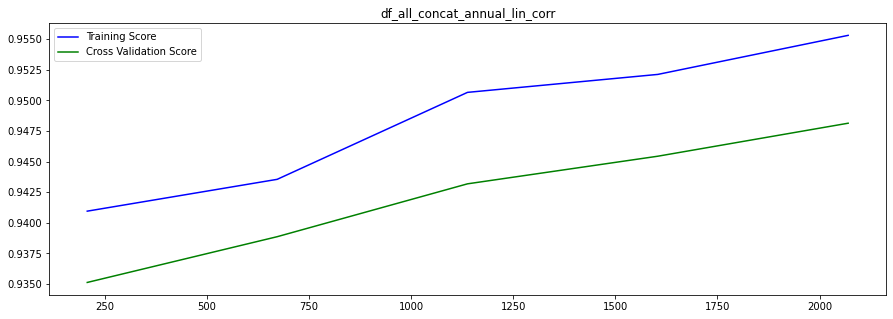

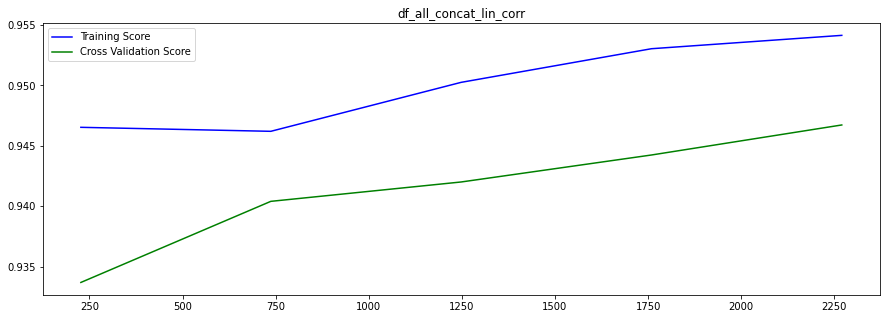

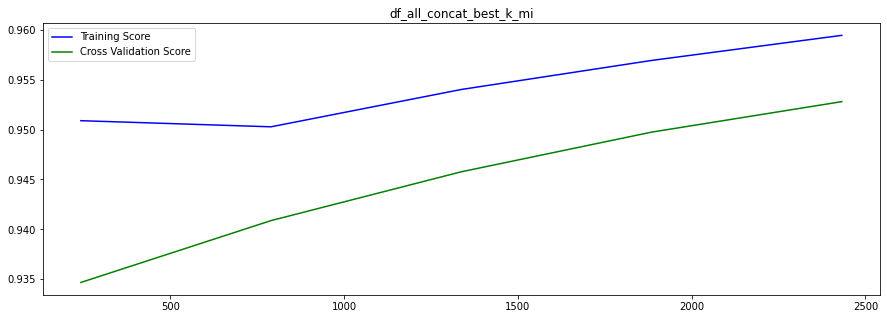

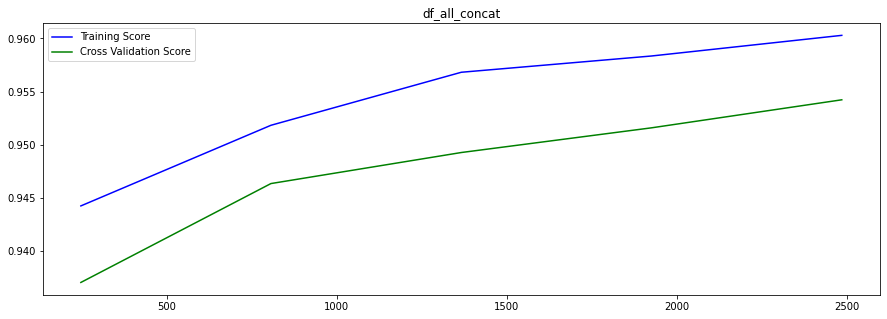

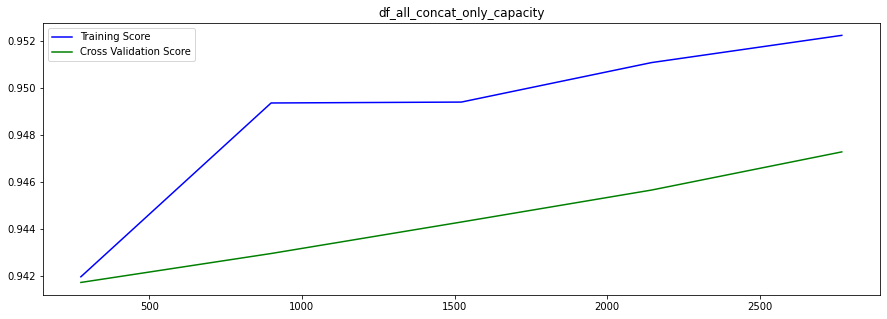

In [75]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, KNeighborsRegressor(n_neighbors=14),df_X_y['X_train'], df_X_y['y_train'])

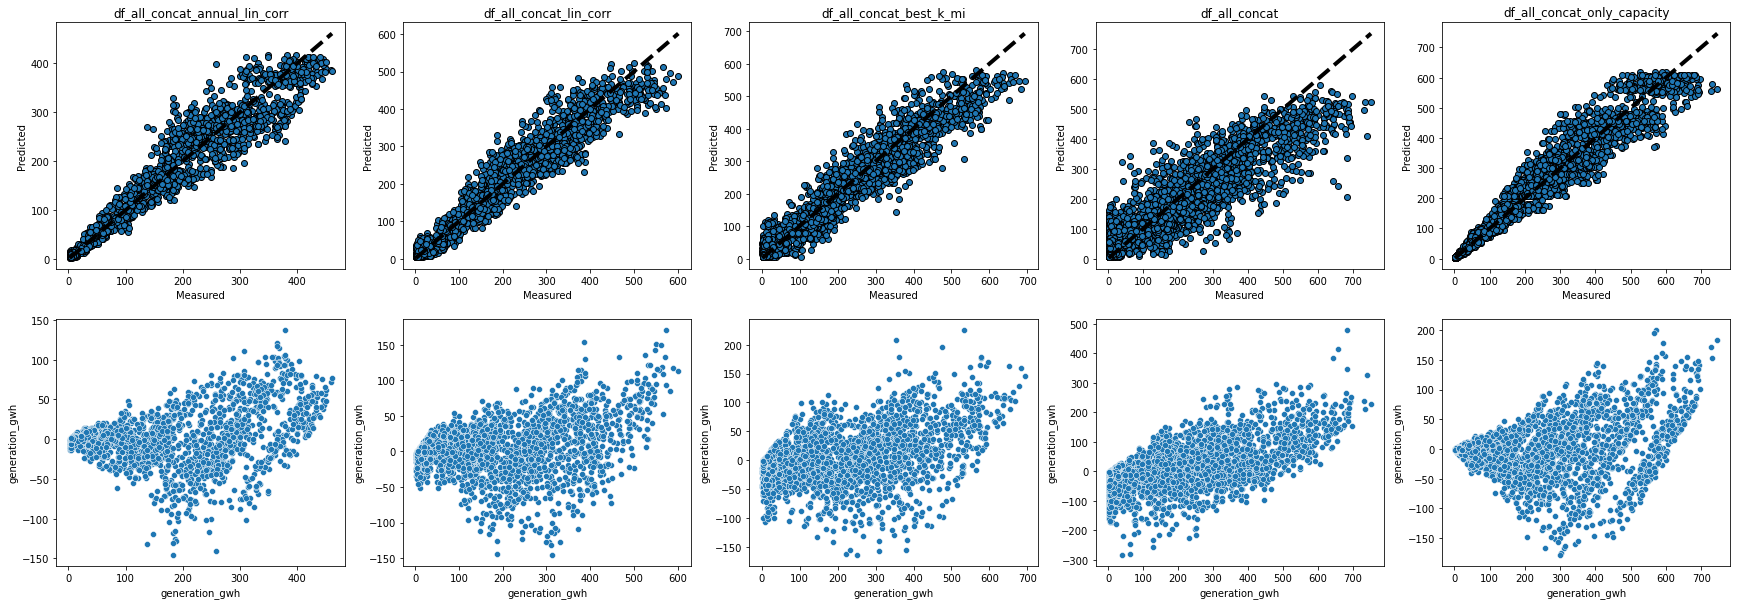

In [76]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train_scaled'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

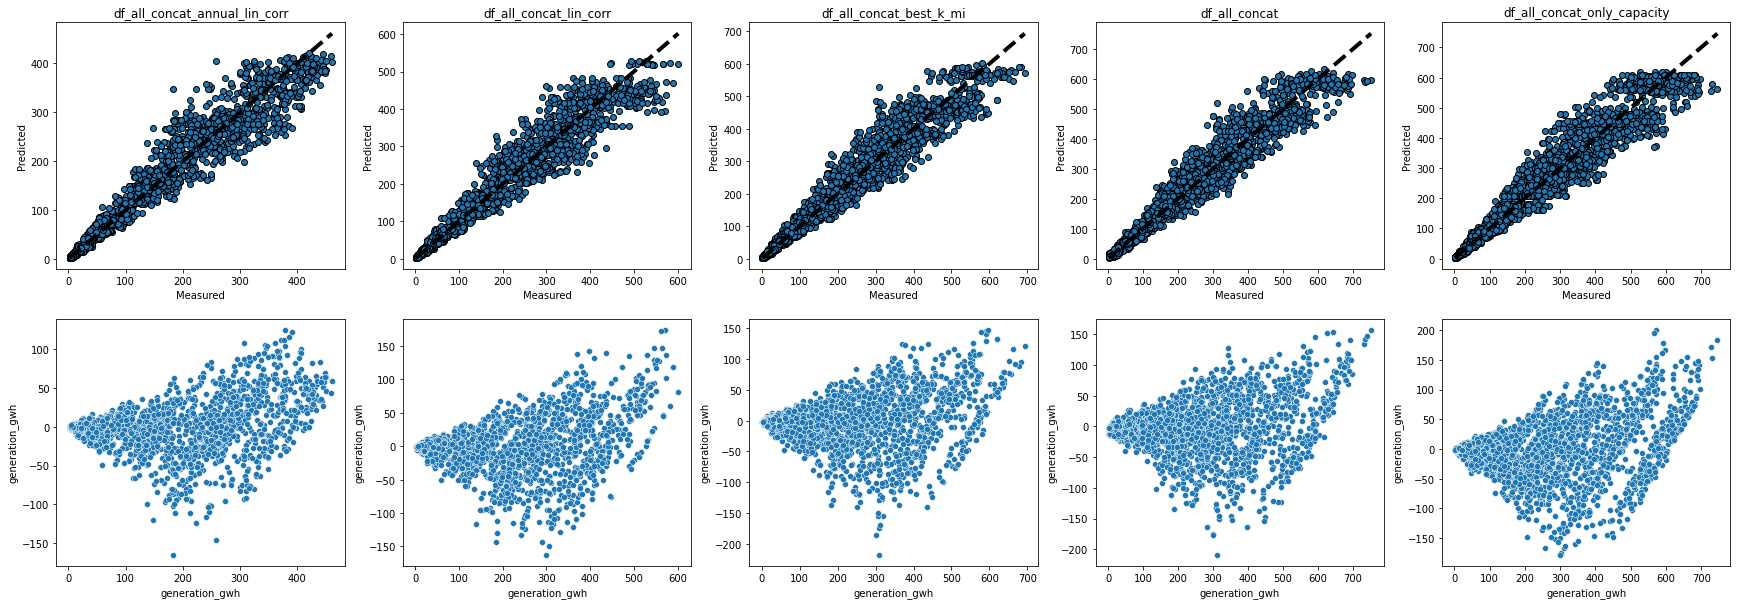

In [77]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    predicted = cross_val_predict(KNeighborsRegressor(n_neighbors=14), df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [78]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # results = utils.performance_metrics_cross_val(df_X_y['X_train'], df_X_y['y_train'], rf_grid.best_estimator_, k)
    results = utils.performance_metrics_cross_val(df_X_y['X_train_scaled'], df_X_y['y_train'], KNeighborsRegressor(n_neighbors = 14), k)
    print(k)
    print(results)

df_all_concat_annual_lin_corr
{'test_r2': 0.9415122897251222, 'test_mean_squared_error': 931.8861114932643, 'test_mean_absolute_error': 19.13029003533872, 'test_root_mean_squared_error': 30.523502113580996}
df_all_concat_lin_corr
{'test_r2': 0.9440845648622374, 'test_mean_squared_error': 1222.3655746429768, 'test_mean_absolute_error': 23.877818523762013, 'test_root_mean_squared_error': 34.94036564966887}
df_all_concat_best_k_mi
{'test_r2': 0.9281474566288048, 'test_mean_squared_error': 1986.080168372464, 'test_mean_absolute_error': 31.32517847976713, 'test_root_mean_squared_error': 44.54352452967587}
df_all_concat
{'test_r2': 0.7882406251319027, 'test_mean_squared_error': 6706.258041965683, 'test_mean_absolute_error': 60.38282172756924, 'test_root_mean_squared_error': 81.85694493389991}
df_all_concat_only_capacity
{'test_r2': 0.9471579631562956, 'test_mean_squared_error': 1789.4830204267134, 'test_mean_absolute_error': 26.63603718887054, 'test_root_mean_squared_error': 42.2607540839056

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors = 14)
knn_model.fit(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_train'])
y_pred = knn_model.predict(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_test'])
residuals = dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'] - y_pred
utils.adjusted_r2(dataframes_dict_X_y['df_all_concat_best_k_mi']['X_train'], dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred)
print(r2_score(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], y_pred))
# y_pred = model_poly_knn.predict(X_test)
sns.scatterplot(dataframes_dict_X_y['df_all_concat_best_k_mi']['y_test'], residuals)

# PREDICTION INTERVALS
https://mapie.readthedocs.io/en/latest/tutorial_regression.html
https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/
https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression
https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

## Intervals with Gradient Tree Boosting

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]

learning_rate = [np.around(x,3) for x in np.arange(0.005, 2.001, 0.005)]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                # 'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes,
                'learning_rate': learning_rate
            }



In [ ]:
gbr_grid = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = param_grid, n_iter = 30, cv=5, verbose = 2, n_jobs=4)

In [ ]:
gbr_grid.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid.best_estimator_

In [ ]:
gbr_grid.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

In [ ]:
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=LOWER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=UPPER_ALPHA,
    greater_is_better=False,  # maximize the negative loss
)

In [ ]:
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

param_grid_lower = param_grid.copy()
# param_grid_lower['loss'] = 'quantile'
# param_grid_lower['alpha'] = LOWER_ALPHA

param_grid_upper = param_grid.copy()
# param_grid_upper['loss'] = 'quantile'
# param_grid_upper['alpha'] = UPPER_ALPHA

### Lower

In [ ]:
gbr_grid_lower = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=LOWER_ALPHA), param_distributions = param_grid_lower, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_05p_scorer)

In [ ]:
gbr_grid_lower.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_lower.best_estimator_

In [ ]:
gbr_grid_lower.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

### Upper

In [ ]:
gbr_grid_upper = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile', alpha=UPPER_ALPHA), param_distributions = param_grid_upper, n_iter = 30, cv=5, verbose = 2, n_jobs=4, scoring=neg_mean_pinball_loss_95p_scorer)

In [ ]:
gbr_grid_upper.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
gbr_grid_upper.best_estimator_

In [ ]:
gbr_grid_upper.score(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])

In [ ]:
# Set lower and upper quantile


# N_ESTIMATORS = 100
# MAX_DEPTH = 5

# Each model has to be separate
GradientBoostingRegressor(alpha=0.05, learning_rate=0.385, loss='quantile',
                          max_depth=260, max_leaf_nodes=430,
                          min_samples_leaf=50, min_samples_split=20,
                          n_estimators=60)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# The mid model will use the default
# mid_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
#                           max_leaf_nodes=300, min_samples_leaf=10,
#                           min_samples_split=20, n_estimators=70)
mean_model = GradientBoostingRegressor(learning_rate=0.245, max_depth=430,
                          max_leaf_nodes=300, min_samples_leaf=10,
                          min_samples_split=20, n_estimators=70)
# mid_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(alpha=0.95, learning_rate=0.155, loss='quantile',
                          max_depth=350, max_leaf_nodes=320,
                          min_samples_leaf=60, min_samples_split=30,
                          n_estimators=90)

In [ ]:
_ = lower_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = mean_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])
_ = upper_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions = pd.DataFrame(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'])
predictions['lower'] = lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mid'] = mean_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['upper'] = upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])
predictions['mean'] = mean_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])


# assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

In [ ]:
predictions['upper'] > predictions['lower']

In [ ]:
predictions[(predictions['lower'] > predictions['upper'])]

In [ ]:
predictions[(predictions['lower'] > predictions['mid'])].count()

In [ ]:
predictions[(predictions['mid'] > predictions['upper'])].count()

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'][7491]

In [ ]:
fig = plt.figure(figsize=(30, 15))

# order = np.argsort(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values)
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'], f(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test']), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values,  predictions['mid'], "b.", markersize=10, label="Test observations")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['mid'], "r-", label="Predicted mean")
# plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions, "r-", label="Predicted mean")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['upper'], "k*")
plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values, predictions['lower'], "r*")
# plt.fill_between(
#     dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values.ravel(), predictions['lower'], predictions['upper'], alpha=0.4, label="Predicted 90% interval"
# )
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# plt.ylim(-10, 25)
# plt.legend(loc="upper left")
plt.show()

In [ ]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'],
    lower_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
    upper_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']),
)

In [ ]:
order

In [ ]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y_test'].values[order]

In [ ]:

fig, ax =plt.subplots(2,len(dataframes_dict_X_y), figsize=(30,10))

for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    # predicted = cross_val_predict(rf_grid.best_estimator_, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    predicted = cross_val_predict(mid_model, df_X_y['X_train'], df_X_y['y_train'], cv=5)
    # fig, ax = plt.subplots()
    ax[0,i].scatter(df_X_y['y_train'], predicted, edgecolors=(0, 0, 0))
    ax[0,i].plot([df_X_y['y_train'].min(), df_X_y['y_train'].max()], [df_X_y['y_train'].min(), df_X_y['y_train'].max()], "k--", lw=4)
    ax[0,i].set_xlabel("Measured")
    ax[0,i].set_ylabel("Predicted")
    ax[0,i].set_title(k)
    # plt.show()

    residuals = df_X_y['y_train'] - predicted
    sns.scatterplot(x=df_X_y['y_train'], y=residuals, ax=ax[1, i])

In [ ]:
for i, (k, df_X_y) in enumerate(dataframes_dict_X_y.items()):
    utils.learning_curve_plot(k, mid_model,df_X_y['X_train'], df_X_y['y_train'])

In [ ]:
rf_model = rf_grid.best_estimator_
# XX, yy = make_regression(n_samples=500, n_features=1, noise=20, random_state=59)

In [ ]:
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train'], dataframes_dict_X_y['df_all_concat_lin_corr']['y_train'])

In [ ]:
predictions_try = rf_model.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['X_test'])

predictions_try

## Quantile Regressor on between y real values and y predicted values

<AxesSubplot:xlabel='generation_gwh', ylabel='generation_gwh'>

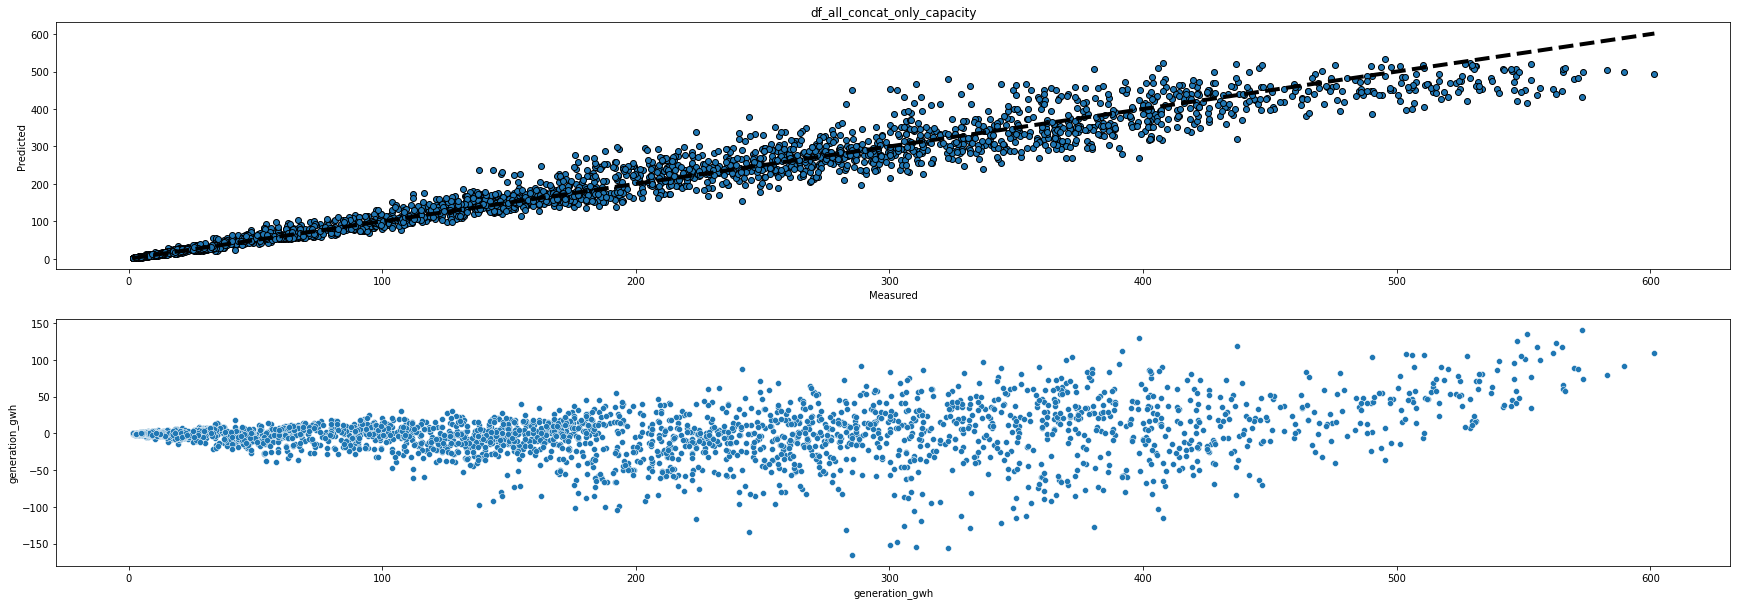

In [86]:

fig, ax =plt.subplots(2, figsize=(30,10))

predicted = cross_val_predict(rf_model, dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'], cv=5)
# fig, ax = plt.subplots()
ax[0].scatter(dataframes_dict_X_y['df_all_concat_lin_corr']['y'], predicted, edgecolors=(0, 0, 0))
ax[0].plot([dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], [dataframes_dict_X_y['df_all_concat_lin_corr']['y'].min(), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].max()], "k--", lw=4)
ax[0].set_xlabel("Measured")
ax[0].set_ylabel("Predicted")
ax[0].set_title(k)
# plt.show()

residuals = dataframes_dict_X_y['df_all_concat_lin_corr']['y'] - predicted
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'] = predicted
sns.scatterplot(x=dataframes_dict_X_y['df_all_concat_lin_corr']['y'], y=residuals, ax=ax[1])

In [87]:
dataframes_dict_X_y['df_all_concat_lin_corr']['predictions']

array([109.81855209, 271.17458217,  65.06488277, ..., 309.30347747,
       258.44430761,   5.41534728])

In [88]:
quantiles = [0.05, 0.95]
predictions_qr = {}
out_bounds_predictions = np.zeros_like(dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, fit_intercept= False, solver='highs', alpha=0)
    qr.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1), dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values)
    dataframes_dict_X_y['df_all_concat_lin_corr'][f'model_qr_{str(quantile)[2:]}_fit'] = qr
    y_pred = qr.predict(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'].reshape(-1, 1))
    predictions_qr[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= dataframes_dict_X_y['df_all_concat_lin_corr']['y'].values
        )

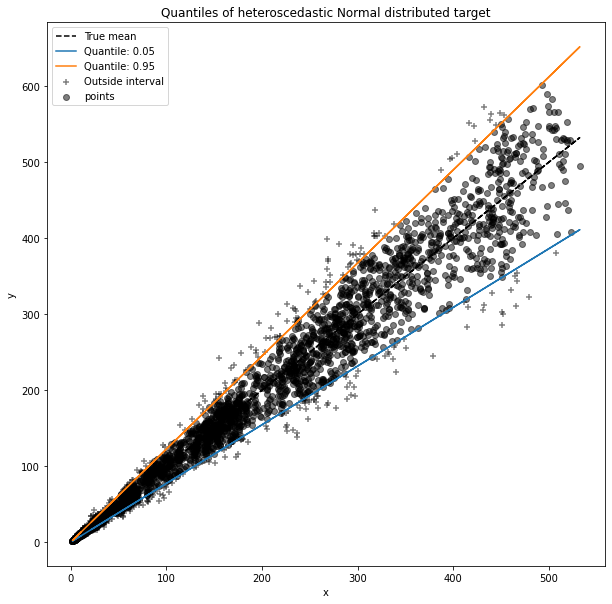

In [89]:
plt.figure(figsize=(10,10))


plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions_qr.items():
    plt.plot(dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'], y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)

plt.scatter(
    dataframes_dict_X_y['df_all_concat_lin_corr']['predictions_all_data'][~out_bounds_predictions],
    dataframes_dict_X_y['df_all_concat_lin_corr']['y'][~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="points",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [90]:
dataframes_dict_X_y['df_all_concat_lin_corr'].keys()

dict_keys(['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_tree_size', 'predictions', 'residuals', 'X_train_scaled', 'X_test_scaled', 'X_scaled', 'best_n_neighbors', 'predictions_all_data', 'model_qr_05_fit', 'model_qr_95_fit'])

In [91]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'].predict(np.array([[600]]))

array([463.3633032])

In [92]:
dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'].predict(np.array([[600]]))

array([734.58022109])

In [93]:
out_bounds_predictions.sum()


474

In [94]:
dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() / (dataframes_dict_X_y['df_all_concat_lin_corr']['y'].count() + out_bounds_predictions.sum())

0.8821481849825957

# EXPORTING THE MODEL

In [95]:
# rf_model = rf_grid.best_estimator_
rf_model.fit(dataframes_dict_X_y['df_all_concat_lin_corr']['X'], dataframes_dict_X_y['df_all_concat_lin_corr']['y'])
joblib.dump(rf_model, utils.DIR_MODELS/"wind_rf_model_regressor.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_05_fit'], utils.DIR_MODELS/"wind_qr_model_05.pkl")
joblib.dump(dataframes_dict_X_y['df_all_concat_lin_corr']['model_qr_95_fit'], utils.DIR_MODELS/"wind_qr_model_95.pkl")


['/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/models/wind_qr_model_95.pkl']

In [105]:
wind_min_capacity = int(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']['capacity_mw'].describe()['min'])
wind_max_capacity = int(dataframes_dict_X_y['df_all_concat_lin_corr']['X_train']['capacity_mw'].describe()['max'])
data_aux = {'min_capacity': [wind_min_capacity],
            'max_capacity': [wind_max_capacity]
            }

In [107]:
wind_minmax_capacity = pd.DataFrame(data_aux)

In [108]:
wind_minmax_capacity.to_csv(utils.DIR_DATA_PROCESSED/"wind_minmax_capacity.csv")